In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pm4py

C:\Users\yeska\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
#%xmode Minimal

## Предобработка

In [9]:
dp = pd.read_csv(r'C:\hackathon_sber_pm_2023\Доставка_продукт.csv', sep=';', encoding='windows-1251')
dp.head(3)

,case,stage,start_time,end_time,client,staff,feedback,status
0,77654086061,Заказ оформлен,05.10.2022 17:57:33,05.10.2022 17:57:40,Ефим Елисеевич Кошелев,NaN,,
1,77654086061,Поступление заказа сборщику,05.10.2022 17:57:40,05.10.2022 17:58:47,Ефим Елисеевич Кошелев,Варлаам Матвеевич Орехов,,
2,77654086061,Сборка заказа,05.10.2022 17:58:47,05.10.2022 18:22:29,Ефим Елисеевич Кошелев,Варлаам Матвеевич Орехов,,


In [10]:
# удалим фрод
dp.drop(index = dp[(dp.client=='Алена Вадимовна Евсеева') | (dp.client=='Елена Александровна Ковалева')].index, inplace=True)

In [62]:
#перевел время в нормальный формат
dp['start_time'] = pd.to_datetime(dp.start_time, format='%d.%m.%Y %H:%M:%S')
dp['end_time'] = pd.to_datetime(dp.end_time, format='%d.%m.%Y %H:%M:%S')

In [63]:
#время каждой операции в минутах
dp['duration'] = (dp.end_time.astype('int64') - dp.start_time.astype('int64')) // 10**9 /60

#день начала и конца каждой операции
dp['start_time_day'] = dp.start_time.dt.date
dp['end_time_day'] = dp.start_time.dt.date

In [47]:
dp.head(1)

,case,stage,start_time,end_time,client,staff,feedback,status,duration,start_time_day,end_time_day
0,77654086061,Заказ оформлен,2022-10-05 17:57:33,2022-10-05 17:57:40,Ефим Елисеевич Кошелев,NaN,,,0.116667,2022-10-05,2022-10-05


In [48]:
dp.client.nunique()

1380

In [49]:
dp.staff.nunique()

204

In [50]:
dp.feedback.unique()

array([' ',
       'Первый и последний раз заказала. Приехала половина заказанного на сумму вдвое меньшую. Никаких сообщений о неполноте заказа, никаких согласований, как в порядочной службе — не было.',
       'пользуйтесь другими сервисами и платите по факту оказанной услуги',
       'Курьер не поднял телефон, когда я пытался связаться с ним',
       'Курьер привез продукты в разорванной упаковке, некоторые продукты были повреждены',
       'Время доставки было большим, чем было указано в приложении',
       'Я просил курьера доставить продукты без упаковки, но он не послушал и привез упакованные продукты',
       'Курьер привез нам неверный заказ',
       'Мы получили поврежденные товары после доставки.',
       'Товар был привезен поздно, чем было обещано',
       'Курьер доставил неудовлетворительное качество продуктов',
       'Курьер нарушил условия регламента доставки',
       'Курьер не обратил внимания на наши специальные требования, и заказ доставлен без них',
       'Достав

In [51]:
dp.status.unique()

array([' ', 'Error', 'Success'], dtype=object)

In [12]:
dp.stage.unique()

array(['Заказ оформлен', 'Поступление заказа сборщику', 'Сборка заказа',
       'Упаковка товара', 'Оплата', 'Отмена заказа',
       'Передача товара курьеру', 'Доставка заказа', 'Проверка заказа',
       'Заказ доставлен', 'Звонок клиенту'], dtype=object)

In [13]:
dp[dp.feedback=='Курьер не поднял телефон, когда я пытался связаться с ним']

,case,stage,start_time,end_time,client,staff,feedback,status,duration,start_time_day,end_time_day
2171,25579042411,Проверка заказа,2022-12-09 20:59:50,2022-12-09 21:01:21,Беляев Юрий Викторович,Аркадин Иван Иванович,"Курьер не поднял телефон, когда я пытался связ...",,1.516667,2022-12-09,2022-12-09


In [14]:
dp[(dp.stage=='Оплата') & (dp.status=='Error')].case.unique()

array([77654086061, 40211944184, 80694742513, ..., 62790066747,
       38682733862, 70813592804], dtype=int64)

In [15]:
indcs = dp[dp.status=='Error'].case.unique()

In [16]:
#процент отмен заказов:
dp.loc[dp.stage=='Отмена заказа'].case.nunique()/dp.case.nunique()*100

24.484071328391106

In [100]:
dp.rename(columns={"duration":'op_time_minutes'}, inplace=True)

In [199]:
#Сводная таблица суммы времени выполнения каждой стадии для каждого кейса
stage_sum_pivot = dp.pivot_table(index = 'case',
              columns ='stage',
              values = 'duration',
              aggfunc = "sum").fillna(0)

stage_sum_pivot

stage,Доставка заказа,Заказ доставлен,Заказ оформлен,Звонок клиенту,Оплата,Отмена заказа,Передача товара курьеру,Поступление заказа сборщику,Проверка заказа,Сборка заказа,Упаковка товара
case,,,,,,,,,,,
10007845189,33.200000,0.066667,0.050000,0.0,0.433333,0.000000,4.416667,1.383333,1.666667,23.900000,2.100000
10013763250,32.950000,0.050000,0.100000,0.0,0.450000,0.000000,3.366667,1.500000,1.800000,23.700000,1.983333
10017161163,0.000000,0.000000,0.083333,0.0,0.433333,0.083333,0.000000,1.150000,0.000000,23.900000,2.133333
10024115929,32.550000,0.100000,0.066667,0.0,0.433333,0.000000,3.500000,1.333333,1.566667,23.750000,3.900000
10027814634,32.833333,0.050000,0.083333,0.0,0.433333,0.000000,4.916667,1.066667,1.666667,23.666667,1.616667
...,...,...,...,...,...,...,...,...,...,...,...
89970176732,33.400000,0.000000,0.083333,0.0,0.400000,0.050000,5.300000,0.716667,0.000000,23.933333,2.183333
89972656636,32.500000,0.066667,0.066667,0.0,0.416667,0.000000,4.200000,1.700000,1.616667,23.950000,1.766667
89976363430,32.566667,0.000000,0.116667,0.0,0.433333,0.066667,3.333333,1.316667,0.000000,23.700000,1.916667


In [200]:
stage_sum_pivot.loc[:,['Доставка заказа']]

stage,Доставка заказа
case,
10007845189,33.200000
10013763250,32.950000
10017161163,0.000000
10024115929,32.550000
10027814634,32.833333
...,...
89970176732,33.400000
89972656636,32.500000
89976363430,32.566667


In [201]:
stage_sum_pivot['Сборка заказа']+ stage_sum_pivot['Передача товара курьеру']

case
10007845189    28.316667
10013763250    27.066667
10017161163    23.900000
10024115929    27.250000
10027814634    28.583333
                 ...    
89970176732    29.233333
89972656636    28.150000
89976363430    27.033333
89978783590    27.416667
89987328229    23.783333
Length: 19964, dtype: float64

In [202]:
stage_sum_pivot['длительность'] = (stage_sum_pivot['Доставка заказа']+stage_sum_pivot['Заказ доставлен'] +\
stage_sum_pivot['Заказ оформлен']+ stage_sum_pivot['Звонок клиенту'] +  stage_sum_pivot['Оплата'] +\
stage_sum_pivot['Отмена заказа'] +  stage_sum_pivot['Поступление заказа сборщику']+\
stage_sum_pivot['Проверка заказа'] +  stage_sum_pivot['Упаковка товара'])//2*2

In [203]:
stage_sum_pivot["Отмена"] = (stage_sum_pivot['Отмена заказа'] >0).astype(str)

In [204]:
palette = ['#00b0f0' for x in stage_sum_pivot['длительность']]

In [205]:
sns.set_theme()
sns.set(rc={'figure.figsize':(12,6)})
plt.style.use('dark_background')

(0.0, 140.0)

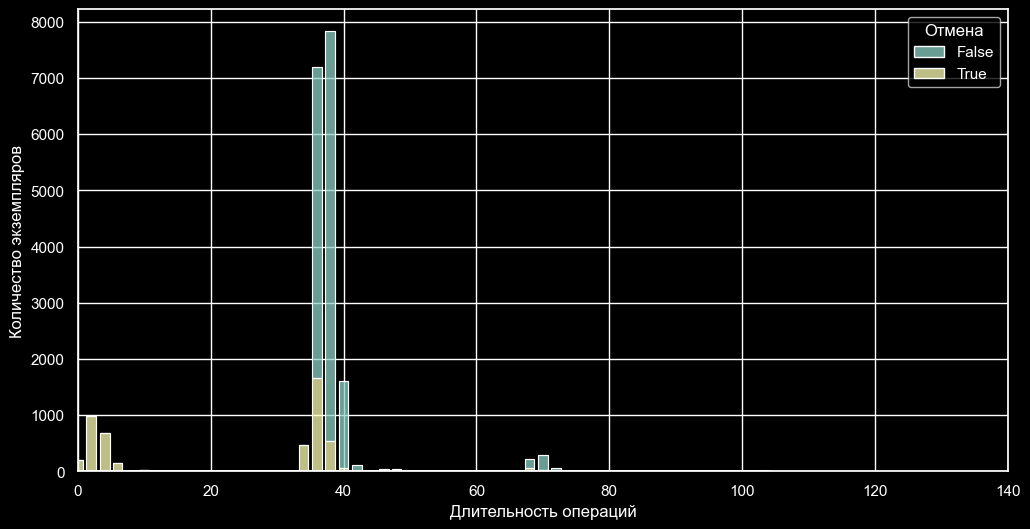

In [206]:
ax=sns.histplot(stage_sum_pivot, x='длительность', shrink=10, color='#00b0f0', hue='Отмена', multiple="stack")
ax.set_yscale("linear")
ax.set(xlabel='Длительность операций', ylabel='Количество экземпляров')
ax.set_xlim(0,140)

In [102]:
dp[(dp.case.isin(ind1))&(dp.stage=='Упаковка товара')].groupby("case").agg({"op_time_minutes":'sum'})

,op_time_minutes
case,
10007845189,2.100000
10013763250,1.983333
10017161163,2.133333
10027814634,1.616667
10030997072,1.900000
...,...
89970176732,2.183333
89972656636,1.766667
89976363430,1.916667


In [103]:
dp[(dp.case.isin(ind2))&(dp.stage=='Упаковка товара')].groupby("case").agg({"op_time_minutes":'sum'})

,op_time_minutes
case,
10024115929,3.900000
10030064755,3.766667
10039547189,4.133333
10056211487,3.983333
10074276688,4.300000
...,...
89691708157,4.200000
89771714893,4.000000
89852595716,4.133333


In [104]:
dp[dp.stage=='Упаковка товара'].sort_values("op_time_minutes", ascending=False)

,case,stage,start_time,end_time,client,staff,feedback,status,op_time_minutes,start_time_day,end_time_day
2566,15168902164,Упаковка товара,2022-10-23 13:56:22,2022-10-23 13:58:50,Шашков Евсей Ефимович,Макаров Измаил Брониславович,,,2.466667,2022-10-23,2022-10-23
138610,57315975917,Упаковка товара,2022-11-17 20:33:59,2022-11-17 20:36:27,Василиса Вячеславовна Григорьева,Антонина Алексеевна Красильникова,,,2.466667,2022-11-17,2022-11-17
29373,67330246534,Упаковка товара,2022-11-25 10:31:46,2022-11-25 10:34:14,Фаина Васильевна Смирнова,Пахомова Алевтина Даниловна,,,2.466667,2022-11-25,2022-11-25
44358,64880418957,Упаковка товара,2022-11-03 17:37:16,2022-11-03 17:39:43,Пономарева Регина Семеновна,Антонина Алексеевна Красильникова,,,2.450000,2022-11-03,2022-11-03
175265,29998754720,Упаковка товара,2022-10-09 19:33:14,2022-10-09 19:35:41,Харлампий Данилович Одинцов,Абсалямов Мифтах Шагеевич,,,2.450000,2022-10-09,2022-10-09
...,...,...,...,...,...,...,...,...,...,...,...
117195,41775504493,Упаковка товара,2022-12-26 23:33:05,2022-12-26 23:34:37,Гремислав Виленович Беспалов,Наина Ефимовна Щукина,,,1.533333,2022-12-26,2022-12-26
94695,87004799172,Упаковка товара,2022-10-15 18:33:34,2022-10-15 18:35:05,Боталиев Аширалы,Фока Юлианович Трофимов,,,1.516667,2022-10-15,2022-10-15
72195,42995416974,Упаковка товара,2022-12-12 18:57:16,2022-12-12 18:58:47,Суворова Нинель Филипповна,Полина Игоревна Вишнякова,,,1.516667,2022-12-12,2022-12-12
153581,83765518976,Упаковка товара,2022-10-17 20:07:15,2022-10-17 20:08:45,Зиновьева Прасковья Игоревна,Варлаам Матвеевич Орехов,,,1.500000,2022-10-17,2022-10-17


## PM4py

In [105]:
event_log = pm4py.format_dataframe(dp, case_id='case', activity_key='stage', timestamp_key='start_time')

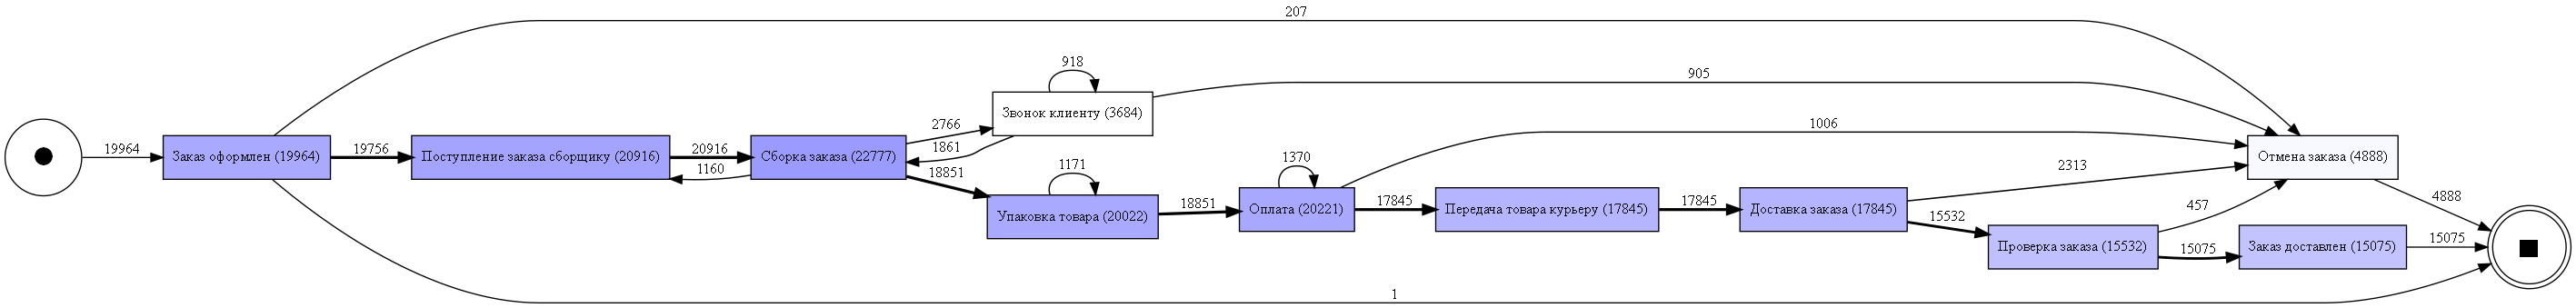

In [106]:
dfg, start_activities, end_activities = pm4py.discover_dfg(event_log)
pm4py.view_dfg(dfg, start_activities, end_activities)

# чекнем сотрудников

In [108]:
dp[dp.stage=='Сборка заказа'].groupby('staff').\
        agg({'op_time_minutes':('mean', 'median', 'min', 'max')}).sort_values(('op_time_minutes', 'mean'), ascending=False)

op_time_minutes                        \
                                          mean     median        min   
staff                                                                  
Филиппов Никанор Федосеевич          23.806048  23.816667  23.333333   
Олимпиада Юльевна Петрова            23.795967  23.783333  23.483333   
Макаров Измаил Брониславович         23.795154  23.800000  23.416667   
Ильина Майя Станиславовна            23.792905  23.800000  23.400000   
Оксана Архиповна Одинцова            23.792197  23.783333  23.466667   
...                                        ...        ...        ...   
Быкова Анжелика Анатольевна          23.771750  23.766667  23.433333   
Васильева Олимпиада Робертовна       23.771585  23.783333  23.366667   
Комиссаров Ратмир Ефстафьевич        23.771285  23.783333  23.500000   
Варфоломей Тимурович Большаков       23.769220  23.766667  23.433333   
Мария Леоновна Попова                23.767082  23.783333  23.383333   

                                           
                                      max  
staff                                      
Филиппов Никанор Федосеевич     24.150000  
Олимпиада Юльевна Петрова       24.150000  
Макаров Измаил Брониславович    24.133333  
Ильина Майя Станиславовна       24.116667  
Оксана Архиповна Одинцова       24.216667  
...                                   ...  
Быкова Анжелика Анатольевна     24.083333  
Васильева Олимпиада Робертовна  24.166667  
Комиссаров Ратмир Ефстафьевич   24.266667  
Варфоломей Тимурович Большаков  24.083333  
Мария Леоновна Попова           24.066667  

[68 rows x 4 columns]

In [111]:
dp[dp.stage=='Передача товара курьеру'].groupby('staff').\
        agg({'op_time_minutes':('mean', 'median', 'min', 'max')}).sort_values(('op_time_minutes', 'median'), ascending=False)

op_time_minutes                      \
                                             mean    median       min   
staff                                                                   
Багов Грегори-Саид Муратович             8.313636  4.616667  1.716667   
Багашвили Спартак Леванович              7.580952  4.550000  1.816667   
Анкудинов Андрей Робертович              7.492466  4.550000  1.550000   
Акулич Олег Александрович                8.214699  4.533333  2.183333   
Агеев Виктор Иванович                    7.424603  4.516667  1.566667   
...                                           ...       ...       ...   
Арнольд Арнольд Григорьевич              6.202000  4.108333  2.250000   
Аракелов Борис Аршакович                 6.172381  4.100000  1.816667   
Адыгёзалов Тельман Аббасгулу оглы        6.200111  4.100000  1.516667   
Арканов Аркадий Михайлович               6.313746  4.100000  2.500000   
Алиханян Исаак Семёнович                 5.314384  4.091667  2.233333   

                                              
                                         max  
staff                                         
Багов Грегори-Саид Муратович       40.100000  
Багашвили Спартак Леванович        40.050000  
Анкудинов Андрей Робертович        40.100000  
Акулич Олег Александрович          40.433333  
Агеев Виктор Иванович              40.433333  
...                                      ...  
Арнольд Арнольд Григорьевич        40.033333  
Аракелов Борис Аршакович           39.766667  
Адыгёзалов Тельман Аббасгулу оглы  39.966667  
Арканов Аркадий Михайлович         40.233333  
Алиханян Исаак Семёнович           39.866667  

[137 rows x 4 columns]

In [113]:
dost = dp[dp.stage=='Доставка заказа'].groupby('staff').\
        agg({'op_time_minutes':('mean', 'median', 'min', 'max', 'count')}).sort_values(('op_time_minutes', 'mean'), ascending=False)
dost

op_time_minutes                        \
                                           mean     median        min   
staff                                                                   
Арчвадзе Тенгиз Григорьевич           32.678000  32.725000  31.416667   
Байжанбаев Жанат Ануарбекович         32.676842  32.700000  31.450000   
Амарантов Борис Георгиевич            32.671365  32.683333  31.366667   
Арсенов Павел Оганезович              32.671134  32.650000  31.200000   
Аржанов Пётр Михайлович               32.664667  32.558333  31.550000   
...                                         ...        ...        ...   
Арканов Аркадий Михайлович            32.496048  32.533333  31.150000   
Акулич Олег Александрович             32.489120  32.491667  31.166667   
Бадалбейли Ахмед-бек Башир оглы       32.487459  32.466667  31.466667   
Ахундов Гусейн Мамедович              32.461395  32.516667  31.050000   
Багашвили Спартак Леванович           32.451361  32.508333  31.250000   

                                                  
                                       max count  
staff                                             
Арчвадзе Тенгиз Григорьевич      33.666667   100  
Байжанбаев Жанат Ануарбекович    34.083333    95  
Амарантов Борис Георгиевич       33.983333   149  
Арсенов Павел Оганезович         34.050000    97  
Аржанов Пётр Михайлович          34.000000   100  
...                                    ...   ...  
Арканов Аркадий Михайлович       33.633333    97  
Акулич Олег Александрович        34.416667   144  
Бадалбейли Ахмед-бек Башир оглы  33.466667   101  
Ахундов Гусейн Мамедович         33.666667    98  
Багашвили Спартак Леванович      33.566667    98  

[137 rows x 5 columns]

# Зацикленность в себя

### "Упаковка товара"

In [19]:
dp.rename(columns={"duration":"op_time_minutes"}, inplace=True)
dp.head(1)

,case,stage,start_time,end_time,client,staff,feedback,status,op_time_minutes,start_time_day,end_time_day
0,77654086061,Заказ оформлен,2022-10-05 17:57:33,2022-10-05 17:57:40,Ефим Елисеевич Кошелев,NaN,,,0.116667,2022-10-05,2022-10-05


In [20]:
Product_packaging = dp.loc[dp['stage'] == 'Упаковка товара']
Product_packaging = Product_packaging.sort_values('start_time')

In [21]:
#Время включая зацикленность в себя
up_time_cycled = Product_packaging.op_time_minutes.sum()
print('Время ',up_time_cycled,'  Количество действий в этом блоке ', Product_packaging['case'].count())

Время  40244.13333333333   Количество действий в этом блоке  20022


In [22]:
#Время без зацикленности в себя
Product_packaging = Product_packaging.sort_values('start_time', ascending=False)
idx = Product_packaging['case'].drop_duplicates().index
up_time_uncycled = Product_packaging.loc[idx,:].op_time_minutes.sum()
print('Время ',up_time_uncycled, '   Количество действий в этом блоке ', Product_packaging.loc[idx,:].case.count())

Время  37891.01666666668    Количество действий в этом блоке  18851


In [23]:
#число кейсов с циклом:
20022 - 18851

1171

In [24]:
#потенциальный фин.эффект
(up_time_cycled - up_time_uncycled)*10

23531.16666666654

### "Звонок клиенту"

In [25]:
call_to_client = dp.loc[dp['stage'] == 'Звонок клиенту'].sort_values('start_time', ascending=False)

In [26]:
#Время включая зацикленность в себя
up_time_cycled = call_to_client.op_time_minutes.sum()
print('Время ',up_time_cycled,'  Количество действий в этом блоке ', call_to_client['case'].count())

Время  8035.866666666667   Количество действий в этом блоке  3684


In [27]:
#Время без зацикленности в себя
idx = call_to_client['case'].drop_duplicates().index
up_time_uncycled = call_to_client.loc[idx,:].op_time_minutes.sum()
print('Время ',up_time_uncycled, '   Количество действий в этом блоке ', call_to_client.loc[idx,:].case.count())

Время  7557.583333333333    Количество действий в этом блоке  2681


In [28]:
#число действий с циклом:
3684 - 2681

1003

In [29]:
#потенциальный фин.эффект
(up_time_cycled - up_time_uncycled)*10

4782.833333333338


### "Оплата"


In [30]:
pay = dp.loc[dp['stage'] == 'Оплата'].sort_values('start_time', ascending=False)

In [31]:
#Время включая зацикленность в себя
up_time_cycled = pay.op_time_minutes.sum()
print('Время ',up_time_cycled,'  Количество действий в этом блоке ', pay['case'].count())

Время  8430.883333333335   Количество действий в этом блоке  20221


In [32]:
#Время без зацикленности в себя
idx = pay['case'].drop_duplicates().index
up_time_uncycled = pay.loc[idx,:].op_time_minutes.sum()
print('Время ',up_time_uncycled, '   Количество действий в этом блоке ', pay.loc[idx,:].case.count())

Время  7860.550000000001    Количество действий в этом блоке  18851


In [33]:
#число действий с циклом:
20221 - 18851

1370

In [34]:
#потенциальный фин.эффект
(up_time_cycled - up_time_uncycled)*10

5703.333333333339

In [35]:
dp.head(3)

,case,stage,start_time,end_time,client,staff,feedback,status,op_time_minutes,start_time_day,end_time_day
0,77654086061,Заказ оформлен,2022-10-05 17:57:33,2022-10-05 17:57:40,Ефим Елисеевич Кошелев,NaN,,,0.116667,2022-10-05,2022-10-05
1,77654086061,Поступление заказа сборщику,2022-10-05 17:57:40,2022-10-05 17:58:47,Ефим Елисеевич Кошелев,Варлаам Матвеевич Орехов,,,1.116667,2022-10-05,2022-10-05
2,77654086061,Сборка заказа,2022-10-05 17:58:47,2022-10-05 18:22:29,Ефим Елисеевич Кошелев,Варлаам Матвеевич Орехов,,,23.700000,2022-10-05,2022-10-05


## Пинг-понг

In [36]:
#Сводная таблица суммы времени выполнения каждой стадии для каждого кейса
stage_count_pivot = dp.pivot_table(index = 'case',
              columns ='stage',
              values = 'op_time_minutes',
              aggfunc = "count").fillna(0)
stage_count_pivot.head(3)

stage,Доставка заказа,Заказ доставлен,Заказ оформлен,Звонок клиенту,Оплата,Отмена заказа,Передача товара курьеру,Поступление заказа сборщику,Проверка заказа,Сборка заказа,Упаковка товара
case,,,,,,,,,,,
10007845189,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
10013763250,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
10017161163,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0


In [37]:
xxx = stage_count_pivot[(stage_count_pivot['Сборка заказа']>1)&(stage_count_pivot['Поступление заказа сборщику']>1)]
xxx.head()

stage,Доставка заказа,Заказ доставлен,Заказ оформлен,Звонок клиенту,Оплата,Отмена заказа,Передача товара курьеру,Поступление заказа сборщику,Проверка заказа,Сборка заказа,Упаковка товара
case,,,,,,,,,,,
10067190529,1.0,1.0,1.0,0.0,1.0,0.0,1.0,2.0,1.0,2.0,1.0
10072042211,1.0,1.0,1.0,0.0,1.0,0.0,1.0,2.0,1.0,2.0,1.0
10092739771,1.0,1.0,1.0,0.0,1.0,0.0,1.0,2.0,1.0,2.0,2.0
10116227603,1.0,1.0,1.0,0.0,1.0,0.0,1.0,2.0,1.0,2.0,1.0
10400601100,1.0,1.0,1.0,0.0,1.0,0.0,1.0,2.0,1.0,2.0,1.0


In [38]:
pp_ind=dp[dp.case.isin(xxx.index)]

In [39]:
pp_list = pp_ind[pp_ind.stage.isin(['Поступление заказа сборщику','Сборка заказа'])].sort_values('start_time', ascending=False)

In [40]:
pp_list['op_time_minutes'].sum()

60759.466666666674

In [41]:
pp_list.loc[:,['case', 'stage', 'op_time_minutes']].drop_duplicates(subset=['case', 'stage',]).sum()

case                                                 115514567208008
stage              Сборка заказаПоступление заказа сборщикуСборка...
op_time_minutes                                         30628.333333
dtype: object

In [42]:
(60759.466666666674-30628.333333333336)*10

301311.3333333334

# Возврат

In [43]:
stage_count_pivot[(stage_count_pivot['Сборка заказа']>1)&(stage_count_pivot['Звонок клиенту']>0)].head()

stage,Доставка заказа,Заказ доставлен,Заказ оформлен,Звонок клиенту,Оплата,Отмена заказа,Передача товара курьеру,Поступление заказа сборщику,Проверка заказа,Сборка заказа,Упаковка товара
case,,,,,,,,,,,
10030750909,0.0,0.0,1.0,3.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0
10057529437,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,2.0,1.0
10083917017,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,2.0,1.0
10196616821,1.0,1.0,1.0,2.0,1.0,0.0,1.0,1.0,1.0,2.0,1.0
10254199685,0.0,0.0,1.0,2.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0


In [44]:
vozvrat_indexes = stage_count_pivot[(stage_count_pivot['Сборка заказа']>1)&(stage_count_pivot['Звонок клиенту']>0)].index

In [45]:
vozvrat_list=dp[dp.case.isin(vozvrat_indexes)].sort_values('start_time')

In [46]:
Return = vozvrat_list.loc[vozvrat_list['stage']=='Сборка заказа'].sort_values('start_time')
Return.head(3)

,case,stage,start_time,end_time,client,staff,feedback,status,op_time_minutes,start_time_day,end_time_day
159553,33537367518,Сборка заказа,2022-10-01 08:17:31,2022-10-01 08:41:12,Балаев Расим Ахмед оглы,Осипов Софон Ефстафьевич,,,23.683333,2022-10-01,2022-10-01
159555,33537367518,Сборка заказа,2022-10-01 08:44:05,2022-10-01 09:07:58,Балаев Расим Ахмед оглы,Осипов Софон Ефстафьевич,,,23.883333,2022-10-01,2022-10-01
147152,54587768065,Сборка заказа,2022-10-01 08:47:46,2022-10-01 09:11:25,Балиев Юрий Николаевич,Горбачева Екатерина Натановна,,,23.650000,2022-10-01,2022-10-01


In [47]:
Return.groupby("case").agg({"op_time_minutes":"first"}).sum()

op_time_minutes    45487.383333
dtype: float64

In [48]:
45487.4*10

454874.0

# fgdfg

In [214]:
stage_sum_pivot = dp.pivot_table(index = 'case',
              columns ='stage',
              values = 'duration',
              aggfunc = "sum")
stage_sum_pivot

stage,Доставка заказа,Заказ доставлен,Заказ оформлен,Звонок клиенту,Оплата,Отмена заказа,Передача товара курьеру,Поступление заказа сборщику,Проверка заказа,Сборка заказа,Упаковка товара
case,,,,,,,,,,,
10007845189,33.200000,0.066667,0.050000,NaN,0.433333,NaN,4.416667,1.383333,1.666667,23.900000,2.100000
10013763250,32.950000,0.050000,0.100000,NaN,0.450000,NaN,3.366667,1.500000,1.800000,23.700000,1.983333
10017161163,NaN,NaN,0.083333,NaN,0.433333,0.083333,NaN,1.150000,NaN,23.900000,2.133333
10024115929,32.550000,0.100000,0.066667,NaN,0.433333,NaN,3.500000,1.333333,1.566667,23.750000,3.900000
10027814634,32.833333,0.050000,0.083333,NaN,0.433333,NaN,4.916667,1.066667,1.666667,23.666667,1.616667
...,...,...,...,...,...,...,...,...,...,...,...
89970176732,33.400000,NaN,0.083333,NaN,0.400000,0.050000,5.300000,0.716667,NaN,23.933333,2.183333
89972656636,32.500000,0.066667,0.066667,NaN,0.416667,NaN,4.200000,1.700000,1.616667,23.950000,1.766667
89976363430,32.566667,NaN,0.116667,NaN,0.433333,0.066667,3.333333,1.316667,NaN,23.700000,1.916667


In [210]:
#Доставка заказа
call_distribution1 = stage_sum_pivot.loc[:, ["Доставка заказа"]].\
            reset_index().groupby("Доставка заказа").agg("count")

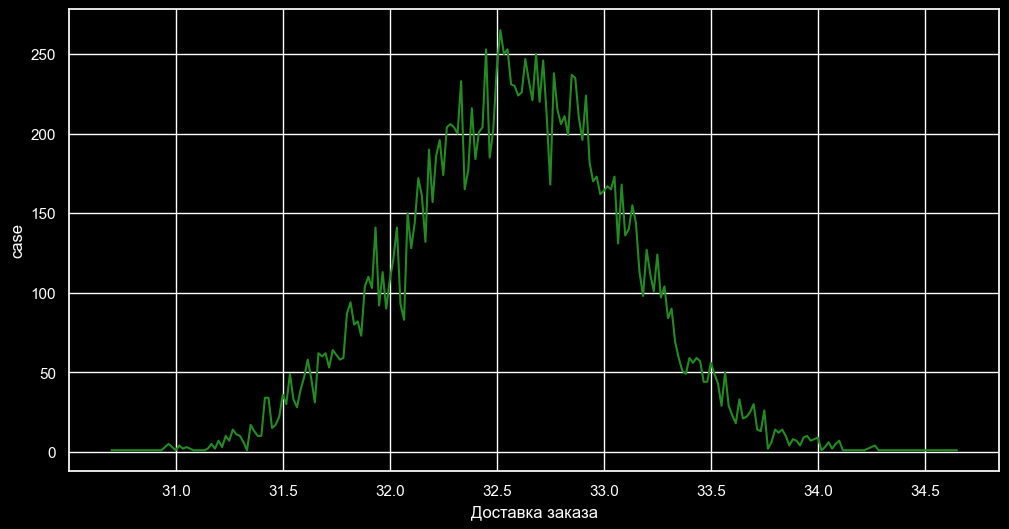

In [211]:
ax = sns.lineplot(call_distribution1, x="Доставка заказа", y='case', color='forestgreen')

In [215]:
#Сборка заказа
call_distribution2 = stage_sum_pivot.loc[:, ["Сборка заказа"]].\
            reset_index().groupby("Сборка заказа").agg("count")

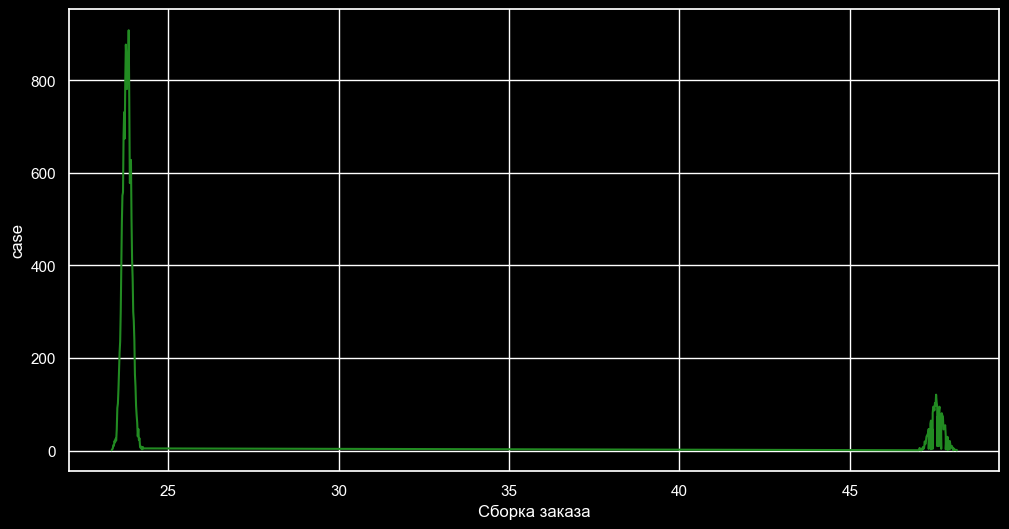

In [217]:
ax = sns.lineplot(call_distribution2, x="Сборка заказа", y='case', color='forestgreen')

In [222]:
dp[(dp.stage == 'Сборка заказа')&(dp.duration>20)]

,case,stage,start_time,end_time,client,staff,feedback,status,duration,start_time_day,end_time_day
2,77654086061,Сборка заказа,2022-10-05 17:58:47,2022-10-05 18:22:29,Ефим Елисеевич Кошелев,Варлаам Матвеевич Орехов,,,23.700000,2022-10-05,2022-10-05
10,40211944184,Сборка заказа,2022-10-10 17:00:23,2022-10-10 17:24:11,Фаина Павловна Максимова,Фока Юлианович Трофимов,,,23.800000,2022-10-10,2022-10-10
18,80694742513,Сборка заказа,2022-10-17 21:46:56,2022-10-17 22:10:28,Якушев Ипат Ефремович,Фока Юлианович Трофимов,,,23.533333,2022-10-17,2022-10-17
26,77917019597,Сборка заказа,2022-12-11 13:11:58,2022-12-11 13:35:47,Бахтыбаев Тохтахун,Демид Анисимович Суворов,,,23.816667,2022-12-11,2022-12-11
36,36725590268,Сборка заказа,2022-10-24 20:37:26,2022-10-24 21:01:12,Якушев Мефодий Федосьевич,Ольга Юльевна Филатова,,,23.766667,2022-10-24,2022-10-24
...,...,...,...,...,...,...,...,...,...,...,...
178337,20684924915,Сборка заказа,2022-11-19 17:28:36,2022-11-19 17:52:23,Дараблы Рза,Варфоломей Тимурович Большаков,,,23.783333,2022-11-19,2022-11-19
178342,48917151565,Сборка заказа,2022-11-04 10:57:04,2022-11-04 11:20:47,Фаина Николаевна Третьякова,г-н Трофимов Герман Устинович,,,23.716667,2022-11-04,2022-11-04
178344,48917151565,Сборка заказа,2022-11-04 11:21:56,2022-11-04 11:45:49,Фаина Николаевна Третьякова,г-н Трофимов Герман Устинович,,,23.883333,2022-11-04,2022-11-04
178349,81477185908,Сборка заказа,2022-10-26 22:41:58,2022-10-26 23:05:33,Зайчиков Василий Фёдорович,Оксана Архиповна Одинцова,,,23.583333,2022-10-26,2022-10-26


In [225]:
stage_sum_pivot[stage_sum_pivot['Сборка заказа']>40]

stage,Доставка заказа,Заказ доставлен,Заказ оформлен,Звонок клиенту,Оплата,Отмена заказа,Передача товара курьеру,Поступление заказа сборщику,Проверка заказа,Сборка заказа,Упаковка товара
case,,,,,,,,,,,
10030750909,NaN,NaN,0.066667,4.966667,NaN,0.100000,NaN,1.250000,NaN,47.766667,NaN
10057529437,33.433333,0.050000,0.100000,2.216667,0.433333,NaN,5.250000,1.066667,1.366667,47.450000,1.950000
10067190529,32.500000,0.050000,0.066667,NaN,0.450000,NaN,1.833333,2.583333,1.800000,47.500000,2.016667
10072042211,32.550000,0.066667,0.033333,NaN,0.433333,NaN,4.133333,2.600000,1.566667,47.333333,1.833333
10083917017,33.583333,0.066667,0.066667,2.683333,0.450000,NaN,5.466667,0.883333,1.583333,47.400000,2.033333
...,...,...,...,...,...,...,...,...,...,...,...
89834536337,32.733333,0.083333,0.083333,NaN,0.433333,NaN,5.383333,2.433333,1.800000,47.783333,1.733333
89837986961,33.700000,NaN,0.033333,2.716667,0.433333,0.083333,4.333333,0.900000,NaN,47.716667,2.183333
89857831223,32.733333,0.116667,0.100000,NaN,0.450000,NaN,4.366667,2.716667,1.633333,47.133333,1.666667


In [226]:
dp[dp.case==10030750909]

,case,stage,start_time,end_time,client,staff,feedback,status,duration,start_time_day,end_time_day
149962,10030750909,Заказ оформлен,2022-10-18 20:16:49,2022-10-18 20:16:53,Василиса Владимировна Лыткина,NaN,,,0.066667,2022-10-18,2022-10-18
149963,10030750909,Поступление заказа сборщику,2022-10-18 20:16:53,2022-10-18 20:18:08,Василиса Владимировна Лыткина,Ольга Юльевна Филатова,,,1.250000,2022-10-18,2022-10-18
149964,10030750909,Сборка заказа,2022-10-18 20:18:08,2022-10-18 20:42:06,Василиса Владимировна Лыткина,Ольга Юльевна Филатова,,,23.966667,2022-10-18,2022-10-18
149965,10030750909,Звонок клиенту,2022-10-18 20:42:06,2022-10-18 20:42:22,Василиса Владимировна Лыткина,Ольга Юльевна Филатова,,,0.266667,2022-10-18,2022-10-18
149966,10030750909,Звонок клиенту,2022-10-18 20:42:22,2022-10-18 20:44:38,Василиса Владимировна Лыткина,Ольга Юльевна Филатова,,,2.266667,2022-10-18,2022-10-18
149967,10030750909,Сборка заказа,2022-10-18 20:44:38,2022-10-18 21:08:26,Василиса Владимировна Лыткина,Ольга Юльевна Филатова,,,23.800000,2022-10-18,2022-10-18
149968,10030750909,Звонок клиенту,2022-10-18 21:08:26,2022-10-18 21:10:52,Василиса Владимировна Лыткина,Ольга Юльевна Филатова,,,2.433333,2022-10-18,2022-10-18
149969,10030750909,Отмена заказа,2022-10-18 21:10:52,2022-10-18 21:10:58,Василиса Владимировна Лыткина,NaN,,,0.100000,2022-10-18,2022-10-18


In [230]:
stage_sum_pivot[stage_sum_pivot['Передача товара курьеру']>30]

stage,Доставка заказа,Заказ доставлен,Заказ оформлен,Звонок клиенту,Оплата,Отмена заказа,Передача товара курьеру,Поступление заказа сборщику,Проверка заказа,Сборка заказа,Упаковка товара
case,,,,,,,,,,,
10323051980,33.016667,0.083333,0.050000,NaN,0.433333,NaN,39.016667,1.000000,1.633333,23.750000,3.733333
10383466708,31.816667,0.066667,0.100000,NaN,0.416667,NaN,39.683333,1.683333,1.533333,23.983333,1.933333
10399727036,33.166667,0.050000,0.100000,NaN,0.400000,NaN,39.783333,1.233333,1.433333,23.716667,2.166667
10451821341,32.966667,0.066667,0.100000,NaN,0.433333,NaN,40.083333,1.050000,2.000000,23.916667,4.183333
10454119140,31.733333,0.083333,0.083333,NaN,0.433333,NaN,39.816667,1.066667,1.600000,23.800000,1.833333
...,...,...,...,...,...,...,...,...,...,...,...
89489711988,31.933333,NaN,0.100000,NaN,0.833333,0.066667,39.200000,1.183333,1.766667,23.700000,1.950000
89646919772,33.333333,0.066667,0.116667,2.7,0.433333,NaN,40.133333,1.533333,1.550000,47.633333,1.933333
89664098402,33.066667,0.100000,0.100000,NaN,0.416667,NaN,39.366667,1.216667,1.900000,23.716667,2.050000


In [231]:
dp[dp.case==10323051980]

,case,stage,start_time,end_time,client,staff,feedback,status,duration,start_time_day,end_time_day
138506,10323051980,Заказ оформлен,2022-12-12 23:04:47,2022-12-12 23:04:50,Евстигней Тарасович Яковлев,NaN,,,0.050000,2022-12-12,2022-12-12
138507,10323051980,Поступление заказа сборщику,2022-12-12 23:04:50,2022-12-12 23:05:50,Евстигней Тарасович Яковлев,Ильина Майя Станиславовна,,,1.000000,2022-12-12,2022-12-12
138508,10323051980,Сборка заказа,2022-12-12 23:05:50,2022-12-12 23:29:35,Евстигней Тарасович Яковлев,Ильина Майя Станиславовна,,,23.750000,2022-12-12,2022-12-12
138509,10323051980,Упаковка товара,2022-12-12 23:29:35,2022-12-12 23:31:28,Евстигней Тарасович Яковлев,Ильина Майя Станиславовна,,,1.883333,2022-12-12,2022-12-12
138510,10323051980,Упаковка товара,2022-12-12 23:31:28,2022-12-12 23:33:19,Евстигней Тарасович Яковлев,Ильина Майя Станиславовна,,,1.850000,2022-12-12,2022-12-12
138511,10323051980,Оплата,2022-12-12 23:33:19,2022-12-12 23:33:45,Евстигней Тарасович Яковлев,Ильина Майя Станиславовна,,Success,0.433333,2022-12-12,2022-12-12
138512,10323051980,Передача товара курьеру,2022-12-12 23:33:45,2022-12-13 00:12:46,Евстигней Тарасович Яковлев,Ахимов Динмухамед Тлеулесович,,,39.016667,2022-12-12,2022-12-12
138513,10323051980,Доставка заказа,2022-12-13 00:12:46,2022-12-13 00:45:47,Евстигней Тарасович Яковлев,Ахимов Динмухамед Тлеулесович,,,33.016667,2022-12-13,2022-12-13
138514,10323051980,Проверка заказа,2022-12-13 00:45:47,2022-12-13 00:47:25,Евстигней Тарасович Яковлев,Ахимов Динмухамед Тлеулесович,,,1.633333,2022-12-13,2022-12-13
138515,10323051980,Заказ доставлен,2022-12-13 00:47:25,2022-12-13 00:47:30,Евстигней Тарасович Яковлев,Ахимов Динмухамед Тлеулесович,,,0.083333,2022-12-13,2022-12-13


In [53]:
stage_sum_pivot[stage_sum_pivot['Доставка заказа'] > 32.6]['Доставка заказа'].sum()*10

2859188.1666666665

In [54]:
stage_sum_pivot[stage_sum_pivot['Сборка заказа'] > 23.779248]['Сборка заказа'].sum()*10

3520101.8333333335

In [55]:
dp[dp.stage=='Звонок клиенту'].describe()

,case,op_time_minutes
count,3.684000e+03,3684.000000
mean,5.011187e+10,2.181288
std,2.349951e+10,1.802805
min,1.003075e+10,0.150000
25%,2.961863e+10,1.708333
50%,5.017841e+10,2.366667
75%,7.062743e+10,2.583333
max,8.992229e+10,10.933333


In [56]:
stage_sum_pivot[stage_sum_pivot['Звонок клиенту'] > 2.366]['Звонок клиенту'].sum()*10

66418.16666666667

In [57]:
stage_sum_pivot[stage_sum_pivot['Упаковка товара'] > 2.015]['Упаковка товара'].sum()*10

236327.66666666666

In [58]:
stage_sum_pivot[stage_sum_pivot['Передача товара курьеру'] > 6.786156]['Передача товара курьеру'].sum()*10

497199.8333333334

In [59]:
#Сводная таблица суммы времени выполнения каждой стадии для каждого кейса
stage_sum_pivot = dp.pivot_table(index = 'case',
              columns ='stage',
              values = 'op_time_minutes',
              aggfunc = "sum").fillna(0)
stage_sum_pivot.shape

(19964, 11)

In [60]:
#Доставка заказа
call_distribution1 = stage_sum_pivot.loc[:, ["Доставка заказа"]].\
            reset_index().groupby("Доставка заказа").agg("count")

#Сборка заказа
call_distribution2 = stage_sum_pivot.loc[:, ["Сборка заказа"]].\
            reset_index().groupby("Сборка заказа").agg("count")

#Звонок клиенту
call_distribution4 = stage_sum_pivot.loc[:, ["Звонок клиенту"]].\
            reset_index().groupby("Звонок клиенту").agg("count")

            #Упаковка товара
call_distribution5 = stage_sum_pivot.loc[:, ["Упаковка товара"]].\
            reset_index().groupby("Упаковка товара").agg("count")

                        #Передача товара курьеру
call_distribution6 = stage_sum_pivot.loc[:, ["Передача товара курьеру"]].\
            reset_index().groupby("Передача товара курьеру").agg("count")

In [61]:
sns.set(rc={'figure.figsize':(6,3)})
plt.style.use('dark_background')

In [72]:
call_distribution1

stage,case
Доставка заказа,
0.000000,2119
30.700000,1
30.850000,1
30.866667,1
30.933333,1
...,...
34.333333,1
34.400000,1
34.416667,1


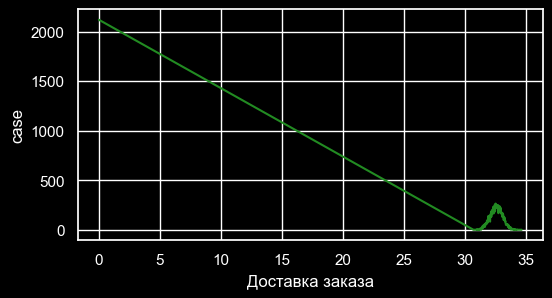

In [62]:

ax = sns.lineplot(call_distribution1, x="Доставка заказа", y='case', color='forestgreen')

In [63]:
ax = sns.lineplot(call_distribution2, x="Доставка заказа", y='case', color='forestgreen')

ValueError: Could not interpret value `Доставка заказа` for `x`. An entry with this name does not appear in `data`.

In [ ]:
ax = sns.lineplot(call_distribution3, x="Доставка заказа", y='case', color='forestgreen')

In [ ]:
ax = sns.lineplot(call_distribution4, x="Звонок клиенту", y='case', color='forestgreen')
ax.set_xlim(0,5)

(0.0, 3.0)

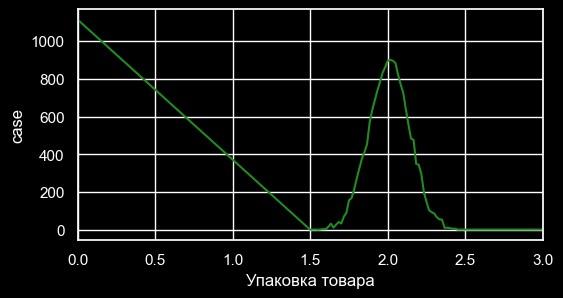

In [64]:

ax = sns.lineplot(call_distribution5, x="Упаковка товара", y='case', color='forestgreen')
ax.set_xlim(0,3)

In [269]:
stage_sum_pivot.drop(columns = ['Заказ доставлен','Заказ оформлен','Оплата']).corr()

stage,Доставка заказа,Звонок клиенту,Отмена заказа,Передача товара курьеру,Поступление заказа сборщику,Проверка заказа,Сборка заказа,Упаковка товара
stage,,,,,,,,
Доставка заказа,1.000000,-0.300298,-0.587796,0.232674,0.006590,0.630279,0.094831,0.485657
Звонок клиенту,-0.300298,1.000000,0.177616,-0.070132,-0.000886,-0.188507,0.521589,-0.294924
Отмена заказа,-0.587796,0.177616,1.000000,-0.143619,0.000919,-0.888967,-0.059071,-0.288555
Передача товара курьеру,0.232674,-0.070132,-0.143619,1.000000,0.006767,0.157337,0.031431,0.113851
Поступление заказа сборщику,0.006590,-0.000886,0.000919,0.006767,1.000000,0.006157,0.073029,0.003739
Проверка заказа,0.630279,-0.188507,-0.888967,0.157337,0.006157,1.000000,0.064726,0.308898
Сборка заказа,0.094831,0.521589,-0.059071,0.031431,0.073029,0.064726,1.000000,0.086609
Упаковка товара,0.485657,-0.294924,-0.288555,0.113851,0.003739,0.308898,0.086609,1.000000


In [220]:
indxs = stage_sum_pivot[stage_sum_pivot['Передача товара курьеру']>30].index
dp['start_time_time'] = dp.start_time.dt.hour
dp

,case,stage,start_time,end_time,client,staff,feedback,status,op_time_minutes,start_time_day,end_time_day,case:concept:name,concept:name,time:timestamp,start_time_time,duration
0,77654086061,Заказ оформлен,2022-10-05 17:57:33,2022-10-05 17:57:40,Ефим Елисеевич Кошелев,NaN,,,0.116667,2022-10-05,2022-10-05,77654086061,Заказ оформлен,2022-10-05 17:57:33,17,0.116667
1,77654086061,Поступление заказа сборщику,2022-10-05 17:57:40,2022-10-05 17:58:47,Ефим Елисеевич Кошелев,Варлаам Матвеевич Орехов,,,1.116667,2022-10-05,2022-10-05,77654086061,Поступление заказа сборщику,2022-10-05 17:57:40,17,1.116667
2,77654086061,Сборка заказа,2022-10-05 17:58:47,2022-10-05 18:22:29,Ефим Елисеевич Кошелев,Варлаам Матвеевич Орехов,,,23.700000,2022-10-05,2022-10-05,77654086061,Сборка заказа,2022-10-05 17:58:47,17,23.700000
3,77654086061,Упаковка товара,2022-10-05 18:22:29,2022-10-05 18:24:31,Ефим Елисеевич Кошелев,Варлаам Матвеевич Орехов,,,2.033333,2022-10-05,2022-10-05,77654086061,Упаковка товара,2022-10-05 18:22:29,18,2.033333
4,77654086061,Оплата,2022-10-05 18:24:31,2022-10-05 18:24:54,Ефим Елисеевич Кошелев,Варлаам Матвеевич Орехов,,Error,0.383333,2022-10-05,2022-10-05,77654086061,Оплата,2022-10-05 18:24:31,18,0.383333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178764,84260931270,Заказ оформлен,2022-12-15 16:46:06,2022-12-15 16:46:12,Бахтыбаев Тохтахун,NaN,,,0.100000,2022-12-15,2022-12-15,84260931270,Заказ оформлен,2022-12-15 16:46:06,16,0.100000
178765,84260931270,Отмена заказа,2022-12-15 16:46:12,2022-12-15 16:46:19,Бахтыбаев Тохтахун,NaN,,,0.116667,2022-12-15,2022-12-15,84260931270,Отмена заказа,2022-12-15 16:46:12,16,0.116667
178766,41729570793,Заказ оформлен,2022-11-23 21:10:18,2022-11-23 21:10:24,Визбор Юрий Иосифович,NaN,,,0.100000,2022-11-23,2022-11-23,41729570793,Заказ оформлен,2022-11-23 21:10:18,21,0.100000
178767,41729570793,Отмена заказа,2022-11-23 21:10:24,2022-11-23 21:10:28,Визбор Юрий Иосифович,NaN,,,0.066667,2022-11-23,2022-11-23,41729570793,Отмена заказа,2022-11-23 21:10:24,21,0.066667


In [228]:
indxs

Int64Index([10323051980, 10383466708, 10399727036, 10451821341, 10454119140,
            10480649997, 10685833456, 10812596954, 10905636775, 10916778661,
            ...
            89274005536, 89279313996, 89337879636, 89355237171, 89394767546,
            89489711988, 89646919772, 89664098402, 89720697303, 89857328278],
           dtype='int64', name='case', length=1253)

In [245]:
dp[(dp.case.isin(indxs)) &( dp.stage=='Передача товара курьеру')].groupby('staff').agg({'op_time_minutes':'mean'})

,op_time_minutes
staff,
Аав Тыну,39.583333
Абаджян Владимир Амвросьевич,39.496970
Абайдулов Гали Мягазович,39.547619
Абалян Эдуард Гайкович,39.390909
Абашев Владимир Владимирович,39.604545
...,...
Байжанбаев Жанат Ануарбекович,39.439583
Байковский Ефим Ицкович,39.702083
Байсеитов Канабек,39.402083


In [260]:
indxs = stage_sum_pivot[stage_sum_pivot['Упаковка товара']>7].index
dp[dp.case.isin(indxs)]

,case,stage,start_time,end_time,client,staff,feedback,status,op_time_minutes,start_time_day,end_time_day,case:concept:name,concept:name,time:timestamp,start_time_time,duration
141327,59691535524,Заказ оформлен,2022-11-08 14:37:32,2022-11-08 14:37:39,Рябов Елисей Измаилович,NaN,,,0.116667,2022-11-08,2022-11-08,59691535524,Заказ оформлен,2022-11-08 14:37:32,14,0.116667
141328,59691535524,Поступление заказа сборщику,2022-11-08 14:37:39,2022-11-08 14:38:44,Рябов Елисей Измаилович,Викентий Игнатович Брагин,,,1.083333,2022-11-08,2022-11-08,59691535524,Поступление заказа сборщику,2022-11-08 14:37:39,14,1.083333
141329,59691535524,Сборка заказа,2022-11-08 14:38:44,2022-11-08 15:02:42,Рябов Елисей Измаилович,Викентий Игнатович Брагин,,,23.966667,2022-11-08,2022-11-08,59691535524,Сборка заказа,2022-11-08 14:38:44,14,23.966667
141330,59691535524,Упаковка товара,2022-11-08 15:02:42,2022-11-08 15:04:46,Рябов Елисей Измаилович,Викентий Игнатович Брагин,,,2.066667,2022-11-08,2022-11-08,59691535524,Упаковка товара,2022-11-08 15:02:42,15,2.066667
141331,59691535524,Упаковка товара,2022-11-08 15:04:46,2022-11-08 15:06:48,Рябов Елисей Измаилович,Викентий Игнатович Брагин,,,2.033333,2022-11-08,2022-11-08,59691535524,Упаковка товара,2022-11-08 15:04:46,15,2.033333
141332,59691535524,Упаковка товара,2022-11-08 15:06:48,2022-11-08 15:08:34,Рябов Елисей Измаилович,Викентий Игнатович Брагин,,,1.766667,2022-11-08,2022-11-08,59691535524,Упаковка товара,2022-11-08 15:06:48,15,1.766667
141333,59691535524,Упаковка товара,2022-11-08 15:08:34,2022-11-08 15:10:39,Рябов Елисей Измаилович,Викентий Игнатович Брагин,,,2.083333,2022-11-08,2022-11-08,59691535524,Упаковка товара,2022-11-08 15:08:34,15,2.083333
141334,59691535524,Оплата,2022-11-08 15:10:39,2022-11-08 15:11:04,Рябов Елисей Измаилович,Викентий Игнатович Брагин,,Success,0.416667,2022-11-08,2022-11-08,59691535524,Оплата,2022-11-08 15:10:39,15,0.416667
141335,59691535524,Передача товара курьеру,2022-11-08 15:11:04,2022-11-08 15:14:27,Рябов Елисей Измаилович,Александров Григорий Васильевич,,,3.383333,2022-11-08,2022-11-08,59691535524,Передача товара курьеру,2022-11-08 15:11:04,15,3.383333
141336,59691535524,Доставка заказа,2022-11-08 15:14:27,2022-11-08 15:46:46,Рябов Елисей Измаилович,Александров Григорий Васильевич,,,32.316667,2022-11-08,2022-11-08,59691535524,Доставка заказа,2022-11-08 15:14:27,15,32.316667


In [254]:
dp[dp.stage=='Упаковка товара']

,case,stage,start_time,end_time,client,staff,feedback,status,op_time_minutes,start_time_day,end_time_day,case:concept:name,concept:name,time:timestamp,start_time_time,duration
3,77654086061,Упаковка товара,2022-10-05 18:22:29,2022-10-05 18:24:31,Ефим Елисеевич Кошелев,Варлаам Матвеевич Орехов,,,2.033333,2022-10-05,2022-10-05,77654086061,Упаковка товара,2022-10-05 18:22:29,18,2.033333
11,40211944184,Упаковка товара,2022-10-10 17:24:11,2022-10-10 17:26:24,Фаина Павловна Максимова,Фока Юлианович Трофимов,,,2.216667,2022-10-10,2022-10-10,40211944184,Упаковка товара,2022-10-10 17:24:11,17,2.216667
19,80694742513,Упаковка товара,2022-10-17 22:10:28,2022-10-17 22:12:28,Якушев Ипат Ефремович,Фока Юлианович Трофимов,,,2.000000,2022-10-17,2022-10-17,80694742513,Упаковка товара,2022-10-17 22:10:28,22,2.000000
27,77917019597,Упаковка товара,2022-12-11 13:35:47,2022-12-11 13:37:45,Бахтыбаев Тохтахун,Демид Анисимович Суворов,,,1.966667,2022-12-11,2022-12-11,77917019597,Упаковка товара,2022-12-11 13:35:47,13,1.966667
37,36725590268,Упаковка товара,2022-10-24 21:01:12,2022-10-24 21:03:15,Якушев Мефодий Федосьевич,Ольга Юльевна Филатова,,,2.050000,2022-10-24,2022-10-24,36725590268,Упаковка товара,2022-10-24 21:01:12,21,2.050000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177953,43364362232,Упаковка товара,2022-11-25 15:50:57,2022-11-25 15:52:59,Кулаков Валентин Артёмович,Миронов Эрнст Давидович,,,2.033333,2022-11-25,2022-11-25,43364362232,Упаковка товара,2022-11-25 15:50:57,15,2.033333
177954,43364362232,Упаковка товара,2022-11-25 15:52:59,2022-11-25 15:55:12,Кулаков Валентин Артёмович,Миронов Эрнст Давидович,,,2.216667,2022-11-25,2022-11-25,43364362232,Упаковка товара,2022-11-25 15:52:59,15,2.216667
177965,40373254196,Упаковка товара,2022-12-03 15:26:13,2022-12-03 15:28:15,Осип Венедиктович Буров,Матвеева Алла Леонидовна,,,2.033333,2022-12-03,2022-12-03,40373254196,Упаковка товара,2022-12-03 15:26:13,15,2.033333
177966,40373254196,Упаковка товара,2022-12-03 15:28:15,2022-12-03 15:30:18,Осип Венедиктович Буров,Матвеева Алла Леонидовна,,,2.050000,2022-12-03,2022-12-03,40373254196,Упаковка товара,2022-12-03 15:28:15,15,2.050000
